In [95]:
# From Tensorflow to import dataset 1.Built-in data library:(Only common dataset,ie tf.keras.datasets.mnist.load_data()) 2.tf.data.Dataset: Dataset=tf.data.Dataset.list_files("filename_pattern")

In [96]:
import tensorflow
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input,Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as k
from tensorflow.keras.callbacks import TensorBoard
from matplotlib import pyplot as plt

In [97]:
##Load image and preprocessing
#load from keras.datasets mnist
(x_train, _) , (x_test, _) = mnist.load_data()
#check the shape of imported data
print(x_train.shape)

(60000, 28, 28)


In [98]:
#as a part of preprocessing to normalize the data.Greyscale image's each pixel is 0 to 255,will make it 0 to 1.
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
#We have to add extra dimension to the dataset cause normally we do 2D convolution ,it will require 4D tensor
x_train =x_train[...,np.newaxis]
x_test =x_test[...,np.newaxis]
#adding some noise in the nwtwork(since the project to denoise)
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
# to clip or control the value of noise
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

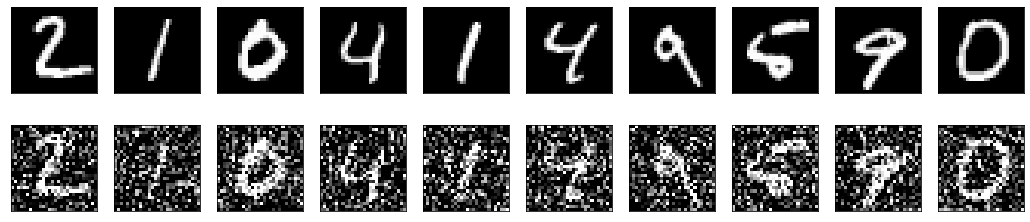

In [99]:
#plot the input image
n=11
plt.figure(figsize=(20, 4))
for i in range(1,n):
    #display original
    ax=plt.subplot(2,n,i+1)
    plt.imshow(x_test[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #display noise version
    ax=plt.subplot(2,n,i+1+n)
    plt.imshow(x_test_noisy[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

In [100]:
##Build the model
#will use functional API


#creating input layer
input_img = Input(shape=(28,28,1)) #already added an additinal axes in early stage,so ok for 4D tensor,here 28,28 is H w 1 is channel

#Encoding
#Adding convolution layer
x= Conv2D(32,(3,3), activation='relu',padding='same')(input_img)# we define the number of filter as 32,kernel 3,3,padding same means output will same shape as input
#Since autoencoder so the layer will be reduce.Will Maxpooling to dense.Downsampling
x=MaxPooling2D((2,2), padding='same')(x)# amxPooling shape 2,2 and will add x at end for functional API structure ie connec t layer
#will repeat
x= Conv2D(32,(3,3), activation='relu',padding='same')(x)
encoded=MaxPooling2D((2,2), padding='same')(x)

#Decoding
x= Conv2D(32,(3,3), activation='relu',padding='same')(encoded)#convolution
x=UpSampling2D((2,2))(x)#upsampling
x= Conv2D(32,(3,3), activation='relu',padding='same')(x)#convolution
x=UpSampling2D((2,2))(x)#upsampling

#Final conv layer to decide the probability
decoded = Conv2D(1,(3,3), activation='sigmoid',padding='same')(x)# sigmoid as two class either white or black

#define model and connect head n tail
autoencoder = Model(input_img, decoded)

autoencoder.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 7, 7, 32)          9248      
_________________________________________________________________
up_sampling2d_10 (UpSampling (None, 14, 14, 32)        0   

In [101]:
##Compiling the model
autoencoder.compile(optimizer='Adam',loss = 'binary_crossentropy')

In [109]:
## Train the Model
#X_train_noisy is our train image,x_train is our target image,batch size impact on RAM ,here image 32/32 small so ok,validation set here is set as test but also can be used split,callback is used for tensorboard to look later
autoencoder.fit(x_train_noisy,x_train, 
               epochs=50,
               batch_size=128,
               shuffle=True,
               validation_data=(x_test_noisy,x_test),
               callbacks=[TensorBoard(log_dir='./tb',histogram_freq=0,write_graph=False)])


Train on 60000 samples, validate on 10000 samples
Epoch 1/50
  128/60000 [..............................] - ETA: 13s

NotFoundError: Failed to create a directory: ./tb\train; No such file or directory [Op:CreateSummaryFileWriter]

In [108]:
#predict the output
decoded_imgs = autoencoder.predict(x_test_noisy)

UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node model_5/conv2d_28/Conv2D (defined at <ipython-input-108-fd7e6e6f4a82>:2) ]] [Op:__inference_distributed_function_10473]

Function call stack:
distributed_function


NameError: name 'decoded_imgs' is not defined

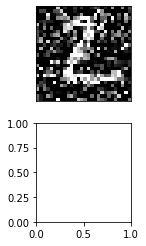

In [105]:
#Plot the output for evaluation

n=10
plt.figure(figsize=(20, 4))
for i in range(1,n):
    #display original
    ax=plt.subplot(2,n,i)
    plt.imshow(x_test_noisy[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #display reconstruction
    ax=plt.subplot(2,n,i+n)
    plt.imshow(decoded_imgs[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()